# 慈善机构精准营销案例

#### 背景：有一个老兵社会组织主要通过发短信和邮寄小礼物的形式募集善款。为了减少成本，该组织决定仅向最优可能提供捐款的人发放信件和礼物。目前该组织有350万条历史营销记录，其中详细记录了营销信息与响应结果。该组织最感兴趣的是最近12-24个月有过捐款行为的人，并希望通过数据分析完成以下两个任务：确定什么人更有可能称为潜在的捐款人：确定这类人中个人的捐款数额可能是多少

#### 需构造二阶段模型,即使用二元逻辑回归预测响应率和线性模型预测潜在消费能力

#### 打开donations.csv，分别使用逻辑回归和线性回归构建多元回归模型，要确定的两个因变量分别是TargetB(Target Gift Flag)和TargetD(Target Gift Amount)。ID为该表的主键,每个取值代表一个观测;其余均为解释变量。接下来我们就开始分析数据并进行建模,此次我们遵循SEMMA建模步骤。


## 2.构造客户价值预测模型(线性)

#### 此处采用线性回归对捐款数额(TargetD)进行建模,建模流程和第一个类似

## 2.1数据导入与采样的S阶段

In [324]:
#导入数据

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
data = pd.read_csv("donations.csv").drop(["ID","TARGET_B"],1)
data.head()

TARGET_D  GiftCnt36  GiftCntAll  GiftCntCard36  GiftCntCardAll  \
0       NaN          2           4              1               3   
1       NaN          1           8              0               3   
2       4.0          6          41              3              20   
3      10.0          3          12              3               8   
4       NaN          1           1              1               1   

   GiftAvgLast  GiftAvg36  GiftAvgAll  GiftAvgCard36  GiftTimeLast  \
0         17.0      13.50        9.25          17.00            21   
1         20.0      20.00       15.88            NaN            26   
2          6.0       5.17        3.73           5.00            18   
3         10.0       8.67        8.50           8.67             9   
4         20.0      20.00       20.00          20.00            21   

       ...       PromCntCardAll  StatusCat96NK  StatusCatStarAll  DemCluster  \
0      ...                   13              A                 0           0   
1      ...                   24              A                 0          23   
2      ...                   22              S                 1           0   
3      ...                   16              E                 1           0   
4      ...                    6              F                 0          35   

   DemAge  DemGender  DemHomeOwner DemMedHomeValue  DemPctVeterans  \
0     NaN          F             U               0               0   
1    67.0          F             U          186800              85   
2     NaN          M             U           87600              36   
3     NaN          M             U          139200              27   
4    53.0          M             U          168100              37   

   DemMedIncome  
0             0  
1             0  
2         38750  
3         38942  
4         71509  

[5 rows x 26 columns]

In [325]:
#给变量分类

data.dtypes
y = ["TARGET_D"]
var_c = ["GiftCnt36","GiftCntAll","GiftCntCard36","GiftCntCardAll","GiftTimeLast",
         "GiftTimeFirst","PromCnt12","PromCnt36","PromCntAll","PromCntCard12",
         "PromCntCard36","PromCntCardAll","DemAge",
         "DemMedHomeValue","DemPctVeterans","DemMedIncome","GiftAvgLast",
         "GiftAvg36","GiftAvgAll","GiftAvgCard36"]
var_d = ['DemGender', 'StatusCat96NK', 'DemCluster', 'DemHomeOwner','StatusCatStarAll']
X = data[var_c + var_d]
Y = data[y]

In [326]:
#连续型变量重要性筛选：

corr_s = abs(data[y + var_c].corr(method = 'spearman'))
corr_s = pd.DataFrame(corr_s.iloc[0,:])
corr_p = abs(data[y + var_c].corr(method = 'pearson'))
corr_p = pd.DataFrame(corr_p.iloc[0,:])
corr_sp = pd.concat([corr_s,corr_p], axis = 1)
corr_sp.columns = ['spearman','pearson']
corr_sp[(corr_sp['spearman'] <= 0.1) & (corr_sp['pearson'] <= 0.1)]

#从连续变量的集合中,剔除以上这些相关性不大的变量
var_c_s = set(var_c) - set(['PromCnt12','PromCnt36',
                            'PromCntCard12','DemAge',
                            'DemPctVeterans','DemMedIncome'])
var_c_s = list(var_c_s)

In [327]:
#离散型变量筛选：

import statsmodels.stats.anova as anova
from statsmodels.formula.api import ols
for i in var_d:
    formula = "TARGET_D ~ " + str(i)
    print(anova.anova_lm(ols(formula,data = data[var_d+['TARGET_D']]).fit()))
    
    
#利用解释变量与被解释变量的方差分析的显著性,我们发现DemHomeOwner不显著，于是将它剔除。
var_d_s = list(set(var_d) - set(["DemHomeOwner"]))
var_d_s

               df         sum_sq     mean_sq         F    PR(>F)
DemGender     2.0    1552.299527  776.149763  5.019571  0.006642
Residual   4840.0  748383.622667  154.624715       NaN       NaN
                   df         sum_sq      mean_sq          F        PR(>F)
StatusCat96NK     5.0   46323.378267  9264.675653  63.690218  1.487957e-64
Residual       4837.0  703612.543927   145.464657        NaN           NaN
                df         sum_sq      mean_sq          F        PR(>F)
DemCluster     1.0    7051.073357  7051.073357  45.948233  1.359482e-11
Residual    4841.0  742884.848837   153.456899        NaN           NaN
                  df         sum_sq     mean_sq        F    PR(>F)
DemHomeOwner     1.0      45.080271   45.080271  0.29102  0.589592
Residual      4841.0  749890.841922  154.904119      NaN       NaN
                      df         sum_sq       mean_sq           F  \
StatusCatStarAll     1.0   34794.586576  34794.586576  235.534691   
Residual          4841.0 

['DemGender', 'StatusCat96NK', 'StatusCatStarAll', 'DemCluster']

## 2.2 变量探索与变量变换的E阶段

DemGender 3
StatusCat96NK 6
StatusCatStarAll 2
DemCluster 54
----------------------------------------
F    5223
M    3925
U     538
Name: DemGender, dtype: int64
----------------------------------------
A    5826
S    2365
F     660
N     574
E     227
L      34
Name: StatusCat96NK, dtype: int64
----------------------------------------
1    5236
0    4450
Name: StatusCatStarAll, dtype: int64
----------------------------------------
40    432
24    401
36    401
35    384
27    331
49    323
12    323
18    321
13    309
30    262
14    248
39    242
0     240
11    236
45    228
43    227
51    220
16    201
41    197
46    196
28    194
2     191
44    185
8     182
17    178
10    175
20    171
21    165
53    158
3     153
42    140
25    135
34    132
23    131
22    125
31    125
1     121
38    118
15    108
26    100
37     99
48     96
5      95
47     86
7      78
29     73
32     72
50     70
9      70
6      53
33     52
4      51
19     50
52     32
Name: DemCluster, dtype:

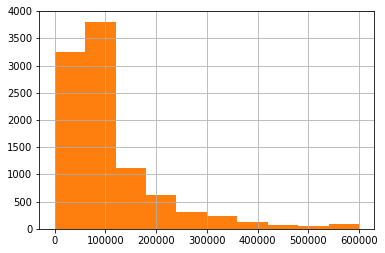

In [328]:
X = data[var_c_s + var_d_s].copy()
Y = data[y].copy()

#查看各个连续变量的分布情况
X[var_c_s].describe().T

#众数-中位数差异法查看异常值
abs((X[var_c_s].mode().iloc[0,] - X[var_c_s].median()) /
    (X[var_c_s].quantile(0.75) - X[var_c_s].quantile(0.25)))

X["PromCntAll"].hist()#发现只是出现双峰，没有太大问题，不需要修改

X["DemMedHomeValue"].hist()#当地人均收入出现0元，怀疑是数据采集过程中用0代替缺失值,将0改为缺失值再进行填补

X['DemMedHomeValue'].replace(0, np.nan, inplace = True)

#通过频次表和取值分布来查看离散变量的分布

for i in var_d_s:
    print(i,len(X[i].value_counts()))

print('-'*40)
for i in var_d_s:
    print(X[i].value_counts())
    print('-'*40)


## 2.3变量修改的M阶段

In [329]:
#查看缺失值及其所占比例

1 - (X.describe().T["count"]) / len(X)

#使用中位数对缺失值进行填补
GiftAvgCard36_fill = X["GiftAvgCard36"].median()
DemMedHomeValue_fill = X["DemMedHomeValue"].median()
X["GiftAvgCard36"].fillna(GiftAvgCard36_fill,inplace = True)
X["DemMedHomeValue"].fillna(DemMedHomeValue_fill,inplace = True)

#查看连续变量的偏度
skew_var_x = {}
for i in var_c_s:
    skew_var_x[i]=abs(X[i].skew())   
skew = pd.Series(skew_var_x).sort_values(ascending=False)
skew

#将偏态严重的(大于1)的连续变量进行对数转换
var_x_ln = skew[skew >= 1].index
for i in var_x_ln:
    if min(X[i]) <= 0:
        X[i] = np.log(X[i] + abs(min(X[i])) + 0.01)
    else:
        X[i] = np.log(X[i])

In [330]:
#分类变量处理：

# 统计每个水平的对应目标变量的均值，和每个水平数量
DemC_group = data[['DemCluster','TARGET_D']].groupby('DemCluster',as_index = False)
DemC_C= DemC_group['TARGET_D'].agg({'mean' : 'mean','count':'count',"median":"median"}).sort_values(["median","mean"])
DemC_C["count_cumsum"] = DemC_C["count"].cumsum()
DemC_C["new_DemCluster"] = DemC_C["count_cumsum"].apply(lambda x:x//(len(data)/10)+1)
DemC_C["new_DemCluster"] = DemC_C["new_DemCluster"].astype(int)
# 将重编码信息保存至数据清洗信息当中
DemCluster_new_class = DemC_C[["DemCluster","new_DemCluster"]].set_index("DemCluster")
# 根据重编码替换原数据
X["DemCluster"] = X["DemCluster"].map(DemCluster_new_class.to_dict()['new_DemCluster'])
new_DemGender = {"F":1,"M":2,"U":3}
X['DemGender'] = X.DemGender.map(new_DemGender)
StatusCat96NK_group = data[['StatusCat96NK','TARGET_D']].groupby('StatusCat96NK', as_index = False)
StatusCat96NK_class = StatusCat96NK_group['TARGET_D'].agg({'mean' : 'mean', 'count':'count',"median":"median"}).sort_values(["median","mean"])
new_StatusCat96NK = {"S":1,"A":2,"E":2,"N":2,"F":2,"L":2}
X['StatusCat96NK'] = X['StatusCat96NK'].map(new_StatusCat96NK)

In [331]:
#  前向选择法筛选变量

import statsmodels.formula.api as smf
def forward_selected(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return selected

In [332]:
XX=pd.concat([X[var_c_s+var_d_s],Y],axis = 1)

In [333]:
final_var = forward_selected(XX,'TARGET_D')

In [334]:
#筛选连续变量
var_c_s = list(set(var_c_s)&set(final_var))

'''
#优化（根据后面模型的变量的P值删除不显著的变量来提高模型）
var_c_s=set(var_c_s)-set(['DemMedHomeValue','GiftCnt36','GiftCntCard36','PromCntCardAll'])
var_c_s=list(var_c_s)
var_c_s
'''
var_c_s

['GiftCnt36',
 'GiftAvgCard36',
 'GiftCntCard36',
 'GiftAvgAll',
 'PromCntCardAll',
 'GiftAvg36',
 'GiftCntAll',
 'GiftAvgLast',
 'DemMedHomeValue']

In [335]:
#筛选分类变量
var_d_s = list(set(var_d_s)&set(final_var))
var_d_s

['DemGender']

In [336]:
model_final = pd.concat([X[var_d_s + var_c_s],Y], axis = 1)
model_final.columns


Index(['DemGender', 'GiftCnt36', 'GiftAvgCard36', 'GiftCntCard36',
       'GiftAvgAll', 'PromCntCardAll', 'GiftAvg36', 'GiftCntAll',
       'GiftAvgLast', 'DemMedHomeValue', 'TARGET_D'],
      dtype='object')

## 2.4建立线性回归模型

In [337]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
X = model_final.iloc[:,:-1]
Y = model_final.iloc[:,-1]
formula = 'TARGET_D ~ ' + '+'.join(final_var) 
donation_model = ols(formula,model_final).fit()
#通过回归模型统计汇总信息,对模型拟合程度,系数相关程度进行评价,可以看到R^2为0.433,说明模型解释了将近一半的被解释变量的变异。
#可以通过解释变量的回归系数P值是否显著来决定是否删除该变量来优化模型。
print(donation_model.summary())

                            OLS Regression Results                            
Dep. Variable:               TARGET_D   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     368.9
Date:                Tue, 16 Oct 2018   Prob (F-statistic):               0.00
Time:                        21:04:39   Log-Likelihood:                -17709.
No. Observations:                4843   AIC:                         3.544e+04
Df Residuals:                    4832   BIC:                         3.551e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -28.0753      2.408    -

In [338]:
#分割捐款金额中的缺失值
donation=model_final[model_final['TARGET_D'].notnull()]
donation_new=model_final[model_final['TARGET_D'].isnull()]

In [339]:
#生成模型使用predict产生预测值,而resid保留训练数据集的残差
pd.DataFrame([donation_model.predict(donation),donation_model.resid],index=['predict','resid']).T.head()

#可以使用predict预测缺失值的捐款数额

predict      resid
2    3.183669   0.816331
3   13.382336  -3.382336
5   13.149344  -2.149344
8   29.931443  10.068557
10   8.048579  -2.048579

In [340]:

from sklearn.linear_model import Lasso,LinearRegression,Ridge,ElasticNet,TheilSenRegressor,HuberRegressor,RANSACRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools

In [341]:
final=donation.copy()
target=final['TARGET_D']
final=final.drop('TARGET_D',1)

X_train, X_test, y_train, y_test = train_test_split(final, target, test_size=0.33, random_state=42)

In [342]:
regs = [
    ['Lasso',Lasso()],
    ['LinearRegression',LinearRegression()],
    ['Ridge',Ridge()],
    ['ElasticNet',ElasticNet()],
    ['TheilSenRegressor',TheilSenRegressor()],
    ['RANSACRegressor',RANSACRegressor()],
    ['HuberRegressor',HuberRegressor()],
    ['SVR',SVR(kernel='linear')],
    ['DecisionTreeRegressor',DecisionTreeRegressor()],
    ['ExtraTreeRegressor',ExtraTreeRegressor()],
    ['AdaBoostRegressor',AdaBoostRegressor(n_estimators=150)],
    ['ExtraTreesRegressor',ExtraTreesRegressor(n_estimators=150)],
    ['GradientBoostingRegressor',GradientBoostingRegressor(n_estimators=150)],
    ['RandomForestRegressor',RandomForestRegressor(n_estimators=150)],
    ['XGBRegressor',XGBRegressor(n_estimators=150)],
]

In [343]:
preds = []
for reg_name,reg in regs:
    print(reg_name)
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    if np.sum(y_pred<0) > 0:
        print('y_pred have',np.sum(y_pred<0),'negative values, we fill it with np.median(y_pred)')
        y_pred[y_pred<0] = np.median(y_pred)
    score = np.sqrt(mean_squared_error(np.log(y_test),np.log(y_pred)))
    preds.append([reg_name,y_pred])

Lasso
y_pred have 9 negative values, we fill it with np.median(y_pred)
LinearRegression
y_pred have 43 negative values, we fill it with np.median(y_pred)
Ridge
y_pred have 43 negative values, we fill it with np.median(y_pred)
ElasticNet
y_pred have 5 negative values, we fill it with np.median(y_pred)
TheilSenRegressor
y_pred have 38 negative values, we fill it with np.median(y_pred)
RANSACRegressor
y_pred have 26 negative values, we fill it with np.median(y_pred)
HuberRegressor
y_pred have 17 negative values, we fill it with np.median(y_pred)
SVR
y_pred have 19 negative values, we fill it with np.median(y_pred)
DecisionTreeRegressor
ExtraTreeRegressor
AdaBoostRegressor
ExtraTreesRegressor
GradientBoostingRegressor
RandomForestRegressor
XGBRegressor


In [344]:
final_results = []
for comb_length in range(1,len(regs)+1):
    print('Model Amount :',comb_length)
    results = []
    for comb in itertools.combinations(preds,comb_length):
        pred_sum = 0
        model_name = []
        for reg_name,pred in comb:
            pred_sum += pred
            model_name.append(reg_name)
        pred_sum /= comb_length
        model_name = '+'.join(model_name)
        score = np.sqrt(mean_squared_error(np.log(y_test),np.log(pred_sum)))
        results.append([model_name,score])
    results = sorted(results,key=lambda x:x[1])
    for model_name,score in results:
        print(model_name,score)
    print()
    final_results.append(results[0])

Model Amount : 1
XGBRegressor 0.39262925301330154
GradientBoostingRegressor 0.3954460137726296
RandomForestRegressor 0.4092711946793501
ExtraTreesRegressor 0.42001298833669026
ElasticNet 0.44475512141370577
Lasso 0.44509856434955225
SVR 0.45584992432482574
HuberRegressor 0.46733366464943327
TheilSenRegressor 0.5125347653623165
RANSACRegressor 0.5159384286921183
AdaBoostRegressor 0.5240390751022972
Ridge 0.5444905129597714
LinearRegression 0.5453744308595017
DecisionTreeRegressor 0.5660470905583052
ExtraTreeRegressor 0.5802977734190394

Model Amount : 2
GradientBoostingRegressor+XGBRegressor 0.3930627577840143
RandomForestRegressor+XGBRegressor 0.3962856086786202
GradientBoostingRegressor+RandomForestRegressor 0.39687608390144863
ExtraTreesRegressor+XGBRegressor 0.398620104045731
RANSACRegressor+XGBRegressor 0.39925351708709206
ExtraTreesRegressor+GradientBoostingRegressor 0.39939681286571616
RANSACRegressor+GradientBoostingRegressor 0.40077882041388724
Lasso+XGBRegressor 0.402231593168

Ridge+ExtraTreesRegressor+GradientBoostingRegressor 0.41096955915550387
DecisionTreeRegressor+GradientBoostingRegressor+XGBRegressor 0.4111391123392749
Lasso+HuberRegressor+RandomForestRegressor 0.4111530443434895
TheilSenRegressor+SVR+XGBRegressor 0.4111724545377464
Ridge+RANSACRegressor+RandomForestRegressor 0.41162196052364053
LinearRegression+RANSACRegressor+RandomForestRegressor 0.41162882081938884
TheilSenRegressor+SVR+GradientBoostingRegressor 0.4116331034604683
TheilSenRegressor+HuberRegressor+XGBRegressor 0.41215248471156124
RANSACRegressor+ExtraTreeRegressor+XGBRegressor 0.41219357958035563
Lasso+HuberRegressor+ExtraTreesRegressor 0.41247617122407815
RANSACRegressor+DecisionTreeRegressor+XGBRegressor 0.4125270160846156
Ridge+RANSACRegressor+ExtraTreesRegressor 0.41253180560047703
LinearRegression+RANSACRegressor+ExtraTreesRegressor 0.41253946595012525
HuberRegressor+SVR+XGBRegressor 0.4125771032769151
TheilSenRegressor+HuberRegressor+GradientBoostingRegressor 0.41268393952744

RANSACRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3921704497236063
RANSACRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.3926557520930677
ElasticNet+RANSACRegressor+GradientBoostingRegressor+XGBRegressor 0.39455109287448004
RANSACRegressor+SVR+GradientBoostingRegressor+XGBRegressor 0.3948717470626004
TheilSenRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39493395807683856
SVR+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3950669311834132
TheilSenRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.3953483429345043
SVR+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.3956084422075437
Lasso+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3957326401655906
Lasso+RANSACRegressor+GradientBoostingRegressor+XGBRegressor 0.39580190611260374
ElasticNet+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39581194161119687
ElasticNet+RANSACRegressor

LinearRegression+ElasticNet+AdaBoostRegressor+RandomForestRegressor 0.43124476946086815
Ridge+ElasticNet+AdaBoostRegressor+RandomForestRegressor 0.4312679370506835
LinearRegression+DecisionTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor 0.43129963660284004
Ridge+DecisionTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor 0.4313169089641274
LinearRegression+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor 0.4313235516941495
Ridge+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor 0.43133889342028175
LinearRegression+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor 0.43136460098408896
Ridge+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor 0.43137224336410335
TheilSenRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor 0.431429402032002
ElasticNet+DecisionTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor 0.4314537925629616
Ridge+HuberRegressor+SVR+ExtraTreeRegressor 0.43146781885324564
LinearRegression+Hub

RANSACRegressor+SVR+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3931755784694311
ElasticNet+RANSACRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3934076717647944
RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.3934930955460579
RANSACRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3936172681407719
ElasticNet+RANSACRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.39386886099450497
TheilSenRegressor+RANSACRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3941267648054565
RANSACRegressor+HuberRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.394210499908225
Lasso+RANSACRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3942818722451491
TheilSenRegressor+RANSACRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.394316719689991
RANSACRegressor+HuberRegressor+Extra

Lasso+TheilSenRegressor+AdaBoostRegressor+ExtraTreesRegressor+RandomForestRegressor 0.4120779622800456
Lasso+RANSACRegressor+DecisionTreeRegressor+AdaBoostRegressor+XGBRegressor 0.4120945843471896
Lasso+HuberRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.4120970551689102
Lasso+TheilSenRegressor+HuberRegressor+AdaBoostRegressor+XGBRegressor 0.41211462101976887
TheilSenRegressor+RANSACRegressor+DecisionTreeRegressor+AdaBoostRegressor+RandomForestRegressor 0.41211576030305996
LinearRegression+SVR+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.4121563519114539
Ridge+RANSACRegressor+HuberRegressor+SVR+ExtraTreesRegressor 0.4121615580589148
Ridge+SVR+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.4121631185572258
LinearRegression+RANSACRegressor+HuberRegressor+SVR+ExtraTreesRegressor 0.4121656558246993
Lasso+DecisionTreeRegressor+ExtraTreeRegressor+RandomForestRegressor+XGBRegressor 0.41218939769790924
Lasso+RANSACRegressor

HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+XGBRegressor 0.4205343119118139
Ridge+ElasticNet+RANSACRegressor+SVR+AdaBoostRegressor 0.42053890239291475
LinearRegression+ElasticNet+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.4205599977121384
Lasso+TheilSenRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor 0.4205769984678956
Ridge+ElasticNet+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.42057792495424823
Ridge+TheilSenRegressor+RANSACRegressor+HuberRegressor+DecisionTreeRegressor 0.42063559763916986
LinearRegression+TheilSenRegressor+RANSACRegressor+HuberRegressor+DecisionTreeRegressor 0.42064028741485027
LinearRegression+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor 0.42064964220693235
Ridge+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor 0.4206544244554819
Lasso+LinearRegression+Ridge+RANSACRegressor+RandomForestRegressor 0.42065662304795837
ElasticNet+TheilSe

RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3935592858261225
ElasticNet+TheilSenRegressor+RANSACRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39394133287506233
TheilSenRegressor+RANSACRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3939824693967126
ElasticNet+RANSACRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39405819858184954
ElasticNet+RANSACRegressor+SVR+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39408797792365435
ElasticNet+TheilSenRegressor+RANSACRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.39421884397370255
ElasticNet+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.3944299837533647
RANSACRegressor+HuberRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39445023124162226
Lasso+RANSACReg

ElasticNet+RANSACRegressor+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor+XGBRegressor 0.4062593823974556
TheilSenRegressor+RANSACRegressor+DecisionTreeRegressor+AdaBoostRegressor+RandomForestRegressor+XGBRegressor 0.40626889706472574
Lasso+TheilSenRegressor+HuberRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.4062708991477049
LinearRegression+ElasticNet+RANSACRegressor+DecisionTreeRegressor+ExtraTreesRegressor+RandomForestRegressor 0.4062713955919251
TheilSenRegressor+RANSACRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+XGBRegressor 0.40627485621464604
Ridge+ElasticNet+RANSACRegressor+DecisionTreeRegressor+ExtraTreesRegressor+RandomForestRegressor 0.40628027504273856
LinearRegression+ElasticNet+TheilSenRegressor+HuberRegressor+RandomForestRegressor+XGBRegressor 0.40628824561278254
TheilSenRegressor+HuberRegressor+SVR+AdaBoostRegressor+GradientBoostingRegressor+XGBRegressor 0.40629227870776985
Ridge+ElasticNet+TheilSenRegre

LinearRegression+TheilSenRegressor+SVR+DecisionTreeRegressor+ExtraTreesRegressor+XGBRegressor 0.4100428792534149
Ridge+HuberRegressor+SVR+ExtraTreeRegressor+GradientBoostingRegressor+RandomForestRegressor 0.4100439495948848
LinearRegression+TheilSenRegressor+HuberRegressor+SVR+RandomForestRegressor+XGBRegressor 0.4100471881532623
Ridge+TheilSenRegressor+SVR+DecisionTreeRegressor+ExtraTreesRegressor+XGBRegressor 0.4100484627735371
Ridge+TheilSenRegressor+HuberRegressor+SVR+RandomForestRegressor+XGBRegressor 0.41004910654883975
Lasso+Ridge+TheilSenRegressor+RANSACRegressor+SVR+XGBRegressor 0.41005734433975927
Lasso+LinearRegression+TheilSenRegressor+RANSACRegressor+SVR+XGBRegressor 0.4100575578785742
Lasso+TheilSenRegressor+HuberRegressor+AdaBoostRegressor+ExtraTreesRegressor+RandomForestRegressor 0.41005787079448563
LinearRegression+TheilSenRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreesRegressor+XGBRegressor 0.41005993101026994
Ridge+TheilSenRegressor+HuberRegressor+DecisionT

LinearRegression+ElasticNet+RANSACRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor 0.4136246714996296
Lasso+LinearRegression+ElasticNet+RANSACRegressor+SVR+DecisionTreeRegressor 0.4136259395680366
Lasso+LinearRegression+HuberRegressor+SVR+DecisionTreeRegressor+GradientBoostingRegressor 0.4136284832268325
Lasso+Ridge+HuberRegressor+SVR+DecisionTreeRegressor+GradientBoostingRegressor 0.4136316512802251
Ridge+ElasticNet+RANSACRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor 0.4136327191660727
Lasso+Ridge+ElasticNet+RANSACRegressor+SVR+DecisionTreeRegressor 0.413633618088027
Ridge+TheilSenRegressor+RANSACRegressor+HuberRegressor+SVR+GradientBoostingRegressor 0.4136368101139838
LinearRegression+TheilSenRegressor+RANSACRegressor+HuberRegressor+SVR+GradientBoostingRegressor 0.4136401008701515
TheilSenRegressor+RANSACRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor 0.41364074709418486
Lasso+ElasticNet+SVR+AdaBoostRegressor+ExtraTreesRegressor

Ridge+RANSACRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor 0.4185086909249933
Ridge+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+XGBRegressor 0.4185148457913329
LinearRegression+ElasticNet+DecisionTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+RandomForestRegressor 0.4185414138845341
Lasso+LinearRegression+Ridge+RANSACRegressor+SVR+XGBRegressor 0.41854886844215905
Ridge+ElasticNet+DecisionTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+RandomForestRegressor 0.4185560757495734
Lasso+LinearRegression+TheilSenRegressor+ExtraTreeRegressor+AdaBoostRegressor+RandomForestRegressor 0.418574285201905
LinearRegression+Ridge+RANSACRegressor+SVR+ExtraTreeRegressor+XGBRegressor 0.4185787657182506
LinearRegression+Ridge+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+XGBRegressor 0.4185805716634145
Lasso+LinearRegression+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor 0.4

ElasticNet+TheilSenRegressor+RANSACRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3938446499057809
ElasticNet+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39409256333121306
Lasso+TheilSenRegressor+RANSACRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3948056142413737
Lasso+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3948561919775039
ElasticNet+RANSACRegressor+HuberRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3948904627161064
TheilSenRegressor+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39557539222732857
Lasso+RANSACRegressor+HuberRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3958606248974339
ElasticNet+TheilSenRegressor+RANSACRegr

Lasso+TheilSenRegressor+RANSACRegressor+HuberRegressor+SVR+ExtraTreesRegressor+XGBRegressor 0.40506806960276054
Ridge+ElasticNet+TheilSenRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor 0.40507026574196275
LinearRegression+TheilSenRegressor+RANSACRegressor+AdaBoostRegressor+ExtraTreesRegressor+RandomForestRegressor+XGBRegressor 0.4050710853509684
Ridge+TheilSenRegressor+RANSACRegressor+AdaBoostRegressor+ExtraTreesRegressor+RandomForestRegressor+XGBRegressor 0.405077884922294
Lasso+TheilSenRegressor+SVR+AdaBoostRegressor+ExtraTreesRegressor+RandomForestRegressor+XGBRegressor 0.40507866488367505
Lasso+RANSACRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+GradientBoostingRegressor+RandomForestRegressor 0.40508799263923834
ElasticNet+TheilSenRegressor+HuberRegressor+SVR+ExtraTreeRegressor+GradientBoostingRegressor+RandomForestRegressor 0.40508872194974443
LinearRegression+TheilSenRegressor+HuberRegressor+ExtraTreeRegressor+E

Lasso+ElasticNet+TheilSenRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreesRegressor+RandomForestRegressor 0.407834043768874
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+ExtraTreesRegressor 0.40783813205010694
Lasso+LinearRegression+ElasticNet+HuberRegressor+DecisionTreeRegressor+RandomForestRegressor+XGBRegressor 0.40783858076765267
Ridge+TheilSenRegressor+SVR+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.4078399069149092
LinearRegression+HuberRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.4078408578839521
TheilSenRegressor+RANSACRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+XGBRegressor 0.4078424368770218
Lasso+Ridge+ElasticNet+HuberRegressor+DecisionTreeRegressor+RandomForestRegressor+XGBRegressor 0.4078468448277536
Ridge+HuberRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+Rand

LinearRegression+TheilSenRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor+XGBRegressor 0.4106096707141074
LinearRegression+Ridge+ElasticNet+DecisionTreeRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.4106102475428311
RANSACRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor 0.41061160131168506
Ridge+TheilSenRegressor+RANSACRegressor+HuberRegressor+SVR+ExtraTreeRegressor+XGBRegressor 0.4106118796248396
LinearRegression+TheilSenRegressor+RANSACRegressor+HuberRegressor+SVR+ExtraTreeRegressor+XGBRegressor 0.41061313873034516
LinearRegression+RANSACRegressor+HuberRegressor+SVR+DecisionTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor 0.41061339182866186
Ridge+TheilSenRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor+XGBRegressor 0.41061342852295085
Ridge+ElasticNet+TheilSenRegressor+SVR+AdaBoostRegresso

ElasticNet+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+RandomForestRegressor+XGBRegressor 0.413101686089139
Lasso+Ridge+ElasticNet+TheilSenRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.41310214684380586
Lasso+Ridge+TheilSenRegressor+DecisionTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.413102495170094
Lasso+Ridge+ElasticNet+RANSACRegressor+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor 0.41310365340963945
LinearRegression+ElasticNet+TheilSenRegressor+HuberRegressor+SVR+DecisionTreeRegressor+ExtraTreesRegressor 0.41310500378134585
LinearRegression+Ridge+ElasticNet+RANSACRegressor+DecisionTreeRegressor+ExtraTreeRegressor+XGBRegressor 0.41310516059490493
Ridge+ElasticNet+TheilSenRegressor+HuberRegressor+SVR+DecisionTreeRegressor+ExtraTreesRegressor 0.4131114142508499
Lasso+LinearRegression+TheilSenRegressor+HuberRegressor+SVR+DecisionTreeRegressor+XGBRegressor 0.4131175752612827
L

Lasso+LinearRegression+ElasticNet+SVR+ExtraTreeRegressor+AdaBoostRegressor+XGBRegressor 0.4170009310044065
Lasso+LinearRegression+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor 0.417007105082527
Lasso+Ridge+ElasticNet+SVR+ExtraTreeRegressor+AdaBoostRegressor+XGBRegressor 0.417011917540486
Lasso+Ridge+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor 0.41701454644045544
LinearRegression+Ridge+TheilSenRegressor+HuberRegressor+ExtraTreeRegressor+GradientBoostingRegressor+RandomForestRegressor 0.4170319217521628
Lasso+LinearRegression+ElasticNet+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor 0.4170365135852643
Lasso+Ridge+ElasticNet+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor 0.4170441272340282
LinearRegression+Ridge+HuberRegressor+SVR+ExtraTreeRegressor+GradientBoostingRegressor+RandomForestRegressor 0.417047457554373
LinearRegression+ElasticN

ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3952699292113374
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39561868142316825
ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3957957869532742
Lasso+ElasticNet+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39605676687243624
ElasticNet+RANSACRegressor+HuberRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3963196737191209
Lasso+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39635401984549096
ElasticNet+TheilSenRegressor+RANSACRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+

LinearRegression+ElasticNet+RANSACRegressor+HuberRegressor+SVR+DecisionTreeRegressor+RandomForestRegressor+XGBRegressor 0.4039802300088423
LinearRegression+ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.4039820851430028
Lasso+Ridge+ElasticNet+SVR+DecisionTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.40398396583313495
Ridge+ElasticNet+RANSACRegressor+HuberRegressor+SVR+DecisionTreeRegressor+RandomForestRegressor+XGBRegressor 0.40398541962804213
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+AdaBoostRegressor+RandomForestRegressor+XGBRegressor 0.40398627483487537
Ridge+ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.4039871261397805
Ridge+ElasticNet+TheilSenRegressor+RANSACRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.4039883240818072
ElasticNet+T

Lasso+TheilSenRegressor+SVR+DecisionTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor 0.40697404004887044
ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+XGBRegressor 0.4069745210913321
Lasso+LinearRegression+ElasticNet+TheilSenRegressor+HuberRegressor+DecisionTreeRegressor+RandomForestRegressor+XGBRegressor 0.4069778638840222
LinearRegression+ElasticNet+RANSACRegressor+HuberRegressor+SVR+AdaBoostRegressor+RandomForestRegressor+XGBRegressor 0.4069840224441748
Lasso+Ridge+ElasticNet+TheilSenRegressor+HuberRegressor+DecisionTreeRegressor+RandomForestRegressor+XGBRegressor 0.40698418431347405
ElasticNet+HuberRegressor+SVR+DecisionTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.40698459929884384
Lasso+LinearRegression+RANSACRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor+RandomForestRegressor 0.40698

Lasso+Ridge+ElasticNet+RANSACRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor 0.4090168040743148
LinearRegression+Ridge+ElasticNet+RANSACRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreesRegressor+XGBRegressor 0.40901923976103643
Lasso+Ridge+ElasticNet+RANSACRegressor+ExtraTreeRegressor+AdaBoostRegressor+RandomForestRegressor+XGBRegressor 0.4090195719970893
Lasso+LinearRegression+ElasticNet+TheilSenRegressor+HuberRegressor+SVR+ExtraTreesRegressor+RandomForestRegressor 0.409021574684489
LinearRegression+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreeRegressor+AdaBoostRegressor+XGBRegressor 0.4090237585138767
Lasso+Ridge+ElasticNet+TheilSenRegressor+HuberRegressor+SVR+ExtraTreesRegressor+RandomForestRegressor 0.4090265225861697
Lasso+LinearRegression+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreeRegressor+AdaBoostRegressor+XGBRegressor 0.4090292148361165
Lasso+LinearRegression+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor+Grad

LinearRegression+Ridge+RANSACRegressor+HuberRegressor+DecisionTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+XGBRegressor 0.41229918869489124
Ridge+ElasticNet+HuberRegressor+SVR+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+XGBRegressor 0.41230499128179887
Lasso+LinearRegression+Ridge+TheilSenRegressor+RANSACRegressor+HuberRegressor+ExtraTreesRegressor+RandomForestRegressor 0.4123094641795157
Lasso+LinearRegression+TheilSenRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+RandomForestRegressor 0.41231080734632974
Lasso+LinearRegression+Ridge+ElasticNet+RANSACRegressor+SVR+DecisionTreeRegressor+XGBRegressor 0.4123127659733169
Lasso+LinearRegression+Ridge+ElasticNet+TheilSenRegressor+RANSACRegressor+DecisionTreeRegressor+GradientBoostingRegressor 0.41231541517220216
Lasso+Ridge+TheilSenRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+RandomForestRegressor 0.4123178873462147
Li

LinearRegression+Ridge+ElasticNet+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor+RandomForestRegressor 0.41574583100699225
LinearRegression+Ridge+HuberRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor+XGBRegressor 0.4157634095317548
Lasso+LinearRegression+Ridge+TheilSenRegressor+HuberRegressor+SVR+RandomForestRegressor+XGBRegressor 0.41577433688965715
LinearRegression+Ridge+ElasticNet+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor 0.4157744379023193
Lasso+LinearRegression+Ridge+TheilSenRegressor+HuberRegressor+SVR+ExtraTreesRegressor+XGBRegressor 0.4157804781809789
LinearRegression+ElasticNet+TheilSenRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor 0.4158012422796629
Ridge+ElasticNet+TheilSenRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor 0.4158096918288246
Lasso+LinearRegressi

Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3967717459673945
ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3971029927468636
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39737460623522947
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3974412749329157
ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39754291330817476
ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3975759643978

Lasso+ElasticNet+RANSACRegressor+HuberRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.40455749127952034
LinearRegression+RANSACRegressor+HuberRegressor+SVR+DecisionTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.4045591206567106
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor+RandomForestRegressor+XGBRegressor 0.40456126112961166
LinearRegression+Ridge+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.40456375017722707
Ridge+RANSACRegressor+HuberRegressor+SVR+DecisionTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.40456383609378915
Lasso+LinearRegression+ElasticNet+RANSACRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.4045643607804911
Lasso+LinearRegression+TheilSen

Lasso+LinearRegression+TheilSenRegressor+SVR+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.4068090759288507
Lasso+LinearRegression+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+AdaBoostRegressor+GradientBoostingRegressor+RandomForestRegressor 0.4068104992412874
ElasticNet+TheilSenRegressor+HuberRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+XGBRegressor 0.40681192293140905
Lasso+Ridge+TheilSenRegressor+SVR+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.4068151129655773
Lasso+Ridge+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+AdaBoostRegressor+GradientBoostingRegressor+RandomForestRegressor 0.4068170211139339
Lasso+ElasticNet+TheilSenRegressor+HuberRegressor+SVR+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+XGBRegressor 0.4068208770468797
LinearRegression+ElasticNet+RANSACRegressor+HuberRegressor+SVR+ExtraT

Lasso+LinearRegression+ElasticNet+HuberRegressor+SVR+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor 0.4094242878416771
LinearRegression+Ridge+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+XGBRegressor 0.40942526279147595
Lasso+LinearRegression+Ridge+SVR+DecisionTreeRegressor+ExtraTreeRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.40942837401753746
LinearRegression+Ridge+TheilSenRegressor+RANSACRegressor+HuberRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor 0.4094292143184924
Lasso+ElasticNet+RANSACRegressor+HuberRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+RandomForestRegressor 0.40943072664083563
Ridge+ElasticNet+TheilSenRegressor+RANSACRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+RandomForestRegressor 0.4094310367723079
Lasso+Ridge+Elas

Lasso+Ridge+TheilSenRegressor+HuberRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor 0.4122873556071115
Lasso+LinearRegression+Ridge+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.4122928918628198
LinearRegression+Ridge+ElasticNet+TheilSenRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.412297758090151
LinearRegression+Ridge+RANSACRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor 0.41229883610292356
Lasso+LinearRegression+Ridge+ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+GradientBoostingRegressor 0.4122989807522872
Lasso+LinearRegression+ElasticNet+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+RandomForestRegressor+XGBRegressor 0.41230120386953073
Lasso+LinearRegression

Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.397932756610923
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39843706265458306
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+DecisionTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3984714295610029
ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+SVR+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39856359273259356
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39885142098211357
Lasso+LinearRegression+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingR

Lasso+LinearRegression+Ridge+ElasticNet+TheilSenRegressor+RANSACRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor 0.40575366154737885
LinearRegression+ElasticNet+TheilSenRegressor+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.40576426284294426
Lasso+LinearRegression+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+DecisionTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+XGBRegressor 0.4057703081640731
Ridge+ElasticNet+TheilSenRegressor+HuberRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.4057709463316997
Lasso+Ridge+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+DecisionTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+XGBRegressor 0.40577635594200545
Lasso+LinearRegression+Ridge+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreeRegressor+GradientBoostingR

Lasso+LinearRegression+ElasticNet+TheilSenRegressor+HuberRegressor+SVR+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+XGBRegressor 0.4098835786233398
Lasso+LinearRegression+Ridge+ElasticNet+TheilSenRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+GradientBoostingRegressor+XGBRegressor 0.409887789280839
Lasso+LinearRegression+Ridge+ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+SVR+RandomForestRegressor+XGBRegressor 0.4098888866653571
Lasso+Ridge+ElasticNet+TheilSenRegressor+HuberRegressor+SVR+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+XGBRegressor 0.4098894080244835
LinearRegression+Ridge+TheilSenRegressor+SVR+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.409894587347999
Lasso+LinearRegression+Ridge+ElasticNet+TheilSenRegressor+RANSACRegressor+ExtraTreeRegressor+AdaBoostRegressor+GradientBoostingRegressor+XGBRegressor 0.40989505286874406
Lasso+LinearRegression

Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39932786157028033
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+SVR+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3993714085823639
Lasso+LinearRegression+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3996077161605763
Lasso+Ridge+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39961158846815614
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+HuberRegressor+DecisionTreeRegressor+ExtraTreeRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.39980013205172843
Lasso+LinearRegression+ElasticNet+

Lasso+LinearRegression+Ridge+ElasticNet+HuberRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+XGBRegressor 0.41369344466025354
Lasso+LinearRegression+Ridge+ElasticNet+HuberRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+GradientBoostingRegressor 0.41381437979296215
LinearRegression+Ridge+ElasticNet+TheilSenRegressor+HuberRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+RandomForestRegressor 0.4138952695315727
Lasso+LinearRegression+Ridge+ElasticNet+TheilSenRegressor+HuberRegressor+SVR+ExtraTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+RandomForestRegressor 0.41393381509298405
Lasso+LinearRegression+Ridge+ElasticNet+TheilSenRegressor+HuberRegressor+SVR+DecisionTreeRegressor+AdaBoostRegressor+ExtraTreesRegressor+RandomForestRegressor 0.41396330706969314
Lasso+LinearRegression+Ridge+ElasticNet+TheilSenRegressor+SVR+DecisionTreeRegressor+ExtraTreeRegres

In [345]:
final_results = sorted(final_results,key=lambda x:x[1])
for model_name,score in final_results:
    print(model_name,score)

RANSACRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3921704497236063
XGBRegressor 0.39262925301330154
RANSACRegressor+GradientBoostingRegressor+XGBRegressor 0.3927473807251714
GradientBoostingRegressor+XGBRegressor 0.3930627577840143
RANSACRegressor+SVR+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3931755784694311
RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3935592858261225
ElasticNet+TheilSenRegressor+RANSACRegressor+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3938446499057809
ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3952699292113374
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreesRegressor+GradientBoostingRegressor+RandomForestRegressor+XGBRegressor 0.3967717459673945
Lasso+ElasticNet+TheilSenRegressor+RANSACRegressor+SVR+ExtraTreeRegres

In [346]:
[b for b in zip(itertools.count(),[a[0] for a in regs])]

[(0, 'Lasso'),
 (1, 'LinearRegression'),
 (2, 'Ridge'),
 (3, 'ElasticNet'),
 (4, 'TheilSenRegressor'),
 (5, 'RANSACRegressor'),
 (6, 'HuberRegressor'),
 (7, 'SVR'),
 (8, 'DecisionTreeRegressor'),
 (9, 'ExtraTreeRegressor'),
 (10, 'AdaBoostRegressor'),
 (11, 'ExtraTreesRegressor'),
 (12, 'GradientBoostingRegressor'),
 (13, 'RandomForestRegressor'),
 (14, 'XGBRegressor')]

In [347]:
test=donation_new.copy()
test=test.drop('TARGET_D',1)
pred = np.mean(list(map(lambda x:regs[x][1].predict(test),[0,12,14])),axis=0)


In [348]:
pred

array([17.07202473, 20.4425673 , 21.20620861, ..., 13.96984108,
       11.01253439,  5.42470296])

In [349]:
pred1 = np.mean(list(map(lambda x:regs[x][1].predict(final),[0,12,14])),axis=0)
target
pd.DataFrame([pred1,donation_model.predict(donation),target,pred1-target,donation_model.predict(donation)-target],
             index=['predict','s-predict','target','resid','s-resid']).T.head()
#pd.DataFrame([donation_model.predict(donation),donation_model.resid],index=['predict','resid']).T.head()

predict  s-predict  target     resid    s-resid
0   5.350014   3.183669     4.0  1.350014  -0.816331
1  11.072987  13.382336    10.0  1.072987   3.382336
2  11.651382  13.149344    11.0  0.651382   2.149344
3  31.590046  29.931443    40.0 -8.409954 -10.068557
4   7.503494   8.048579     6.0  1.503494   2.048579

In [350]:
finals=model_final.copy()
finals=finals.drop('TARGET_D',1)
final_pred = np.mean(list(map(lambda x:regs[x][1].predict(finals),[0,12,14])),axis=0)
result=pd.DataFrame([final_pred],index=['predict']).T
result.to_csv('result1.csv')


DemGender  GiftCnt36  GiftAvgCard36  GiftCntCard36  GiftAvgAll  \
0             1   0.698135       2.833213       0.009950    2.224624   
1             1   0.009950       2.525729      -4.605170    2.765060   
4             2   0.009950       2.995732       0.009950    2.995732   
6             2   0.698135       2.995732       0.698135    2.564949   
7             3   0.009950       2.525729      -4.605170    2.442347   
9             3   0.009950       2.995732       0.009950    2.451005   
12            1   0.009950       2.525729      -4.605170    2.995732   
13            2   0.698135       2.525729      -4.605170    2.442347   
15            1   1.793425       1.673351       1.101940    1.791759   
16            2   1.101940       2.708050       0.009950    2.096790   
17            2   1.947338       1.735189       1.101940    1.735189   
18            1   1.388791       3.912023       0.009950    3.561046   
21            2   0.698135       2.525729      -4.605170    2.219203   
22            2   1.101940       2.014903       0.698135    1.882514   
24            3   1.101940       2.525729      -4.605170    2.309561   
25            1   0.698135       2.995732       0.009950    2.803360   
26            2   0.009950       2.995732       0.009950    2.995732   
31            2   1.101940       2.793004       1.101940    2.760010   
32            1   0.698135       2.995732       0.009950    3.481240   
34            2   0.698135       2.708050       0.009950    2.525729   
35            2   1.947338       1.871802       1.388791    1.837370   
38            2   0.009950       3.218876       0.009950    2.615204   
39            2   0.698135       2.772589       0.009950    2.564949   
43            1   0.009950       2.525729      -4.605170    2.995732   
45            1   0.698135       2.525729      -4.605170    2.995732   
46            1   0.698135       2.708050       0.698135    2.425687   
48            2   0.009950       3.218876       0.009950    3.218876   
55            1   1.101940       2.197225       1.101940    1.578979   
57            1   0.698135       2.995732       0.009950    2.639057   
59            1   0.698135       2.525729       0.698135    2.197225   
...         ...        ...            ...            ...         ...   
9630          2   1.388791       2.708050       0.698135    2.491551   
9631          2   0.698135       2.995732       0.009950    3.178054   
9632          1   1.388791       3.121042       1.101940    2.593761   
9635          1   0.698135       2.302585       0.009950    2.512035   
9640          2  -4.605170       2.525729      -4.605170    2.639057   
9641          2   1.388791       2.302585       0.009950    2.169054   
9642          1   0.009950       2.525729      -4.605170    2.224624   
9644          1   1.101940       2.862201       0.698135    2.613007   
9647          1   1.388791       2.995732       0.698135    2.944439   
9648          1   1.611436       2.484907       1.101940    2.190536   
9650          1   0.009950       2.525729      -4.605170    2.607861   
9652          2   1.101940       2.525729      -4.605170    2.555676   
9655          2   0.698135       1.609438       0.009950    2.525729   
9656          2   0.698135       2.525729      -4.605170    2.876386   
9659          1   1.388791       2.169054       1.388791    2.010895   
9660          2   1.388791       2.014903       0.698135    2.140066   
9663          1   1.388791       2.525729      -4.605170    1.981001   
9668          1   0.009950       2.708050       0.009950    2.708050   
9669          1   1.793425       2.995732       1.101940    2.484907   
9670          1   0.698135       2.772589       0.698135    2.339881   
9671          2  -4.605170       2.525729      -4.605170    2.772589   
9672          2   0.009950       2.995732       0.009950    2.639057   
9674          1   0.009950       3.218876       0.009950    3.218876   
9675          3   0.009950       2.995732     